# Tesla Stock Analysis

### Getting Data

In [2]:
import pandas as pd

tesla = pd.read_csv("TSLA Testing.csv")

print(tesla)

           Date        Open        High         Low       Close   Adj Close  \
0    2022-06-22  234.503326  246.833328  233.826660  236.086670  236.086670   
1    2022-06-23  237.906662  239.316666  228.636673  235.070007  235.070007   
2    2022-06-24  237.470001  246.066666  236.086670  245.706665  245.706665   
3    2022-06-27  249.366669  252.070007  242.566666  244.919998  244.919998   
4    2022-06-28  244.483337  249.970001  232.343338  232.663330  232.663330   
..          ...         ...         ...         ...         ...         ...   
246  2023-06-14  260.170013  261.570007  250.500000  256.790009  256.790009   
247  2023-06-15  248.399994  258.950012  247.289993  255.899994  255.899994   
248  2023-06-16  258.920013  263.600006  257.209991  260.540009  260.540009   
249  2023-06-20  261.500000  274.750000  261.119995  274.450012  274.450012   
250  2023-06-21  275.130005  276.989990  257.779999  259.459991  259.459991   

        Volume  
0    101107500  
1    104202600  


In [4]:
import matplotlib.pyplot as plt
import pandas as pd

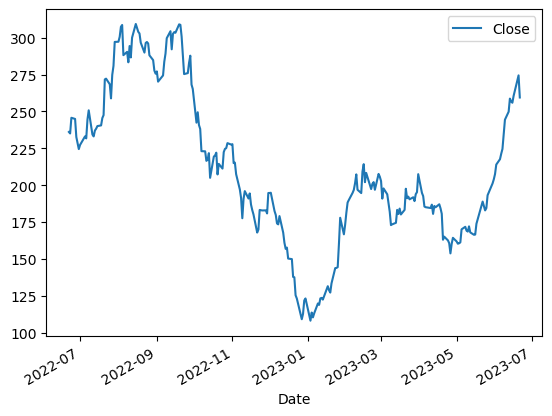

In [6]:
tesla['Date'] = pd.to_datetime(tesla['Date'])

tesla.plot(x='Date', y='Close')

plt.show()

### Simple buy at open and sell at close trading strategy

In [9]:
# dates in datetime
tesla["Date"] = pd.to_datetime(tesla["Date"])
tesla = tesla.sort_values('Date')

# Calculate daily price range (Profit/Loss)
tesla["PnL"] = tesla["Close"] - tesla["Open"]
tesla['Cumulative_PnL'] = tesla['PnL'].cumsum()

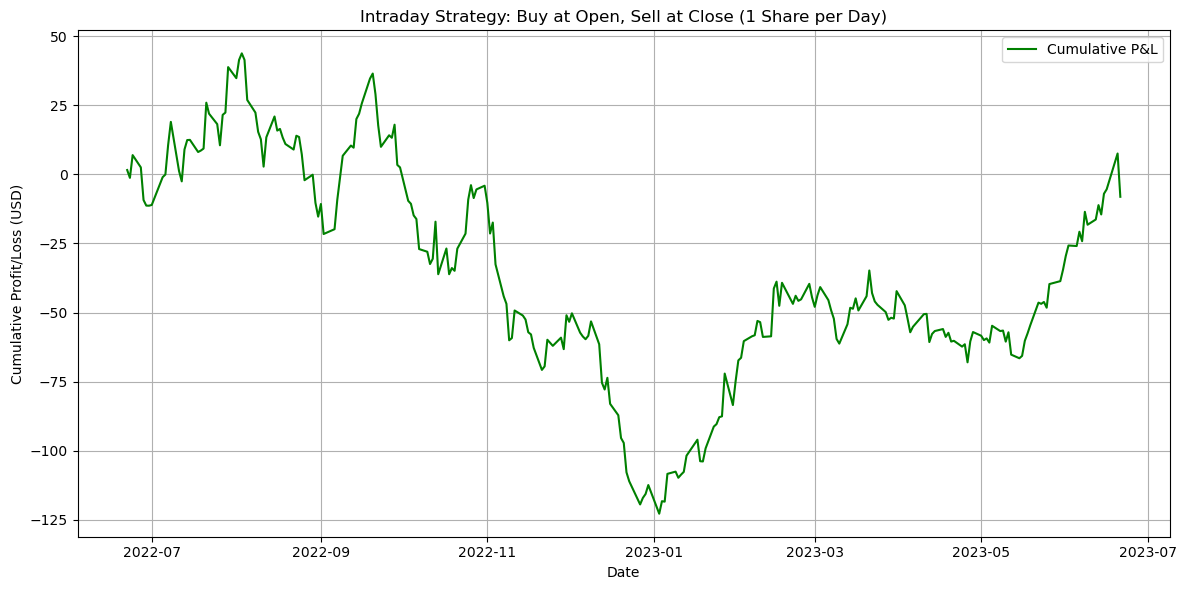

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(tesla['Date'], tesla['Cumulative_PnL'], label='Cumulative P&L', color='green')
plt.title('Intraday Strategy: Buy at Open, Sell at Close (1 Share per Day)')
plt.xlabel('Date')
plt.ylabel('Cumulative Profit/Loss (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
print(f"Total Profit/Loss: ${tesla['PnL'].sum():.2f}")
print(f"Average Daily PnL: ${tesla['PnL'].mean():.2f}")
print(f"Winning Days: {(tesla['PnL'] > 0).sum()}")
print(f"Losing Days: {(tesla['PnL'] < 0).sum()}")
print(f"Max Daily Gain: ${tesla['PnL'].max():.2f}")
print(f"Max Daily Loss: ${tesla['PnL'].min():.2f}")

Total Profit/Loss: $-8.10
Average Daily PnL: $-0.03
Winning Days: 129
Losing Days: 122
Max Daily Gain: $17.31
Max Daily Loss: $-19.02


### Buy or sell when certain price deviation happens close at the end of the day. 

In [16]:
# Dates in datetime
tesla['Date'] = pd.to_datetime(tesla['Date'])
tesla = tesla.sort_values('Date')

# intrday return
tesla['ReturnPct'] = (tesla['Close'] - tesla['Open']) / tesla['Open'] * 100
threshold = 0.9 #percent
tesla["Position"] = 'None'
tesla['PnL'] = 0.0

for i, row in tesla.iterrows():
    if row['ReturnPct'] >= threshold:
        tesla.at[i, "Position"] = "Long"
        tesla.at[i, "PnL"] = row['Open'] - row['Close']
    elif row['ReturnPct'] <= -threshold:
        tesla.at[i, "Position"] = "Short"
        tesla.at[i, "PnL"] = row['Open'] - row['Close']

# Calculate cumulative profit
tesla['Cumulative_PnL'] = tesla['PnL'].cumsum()
        

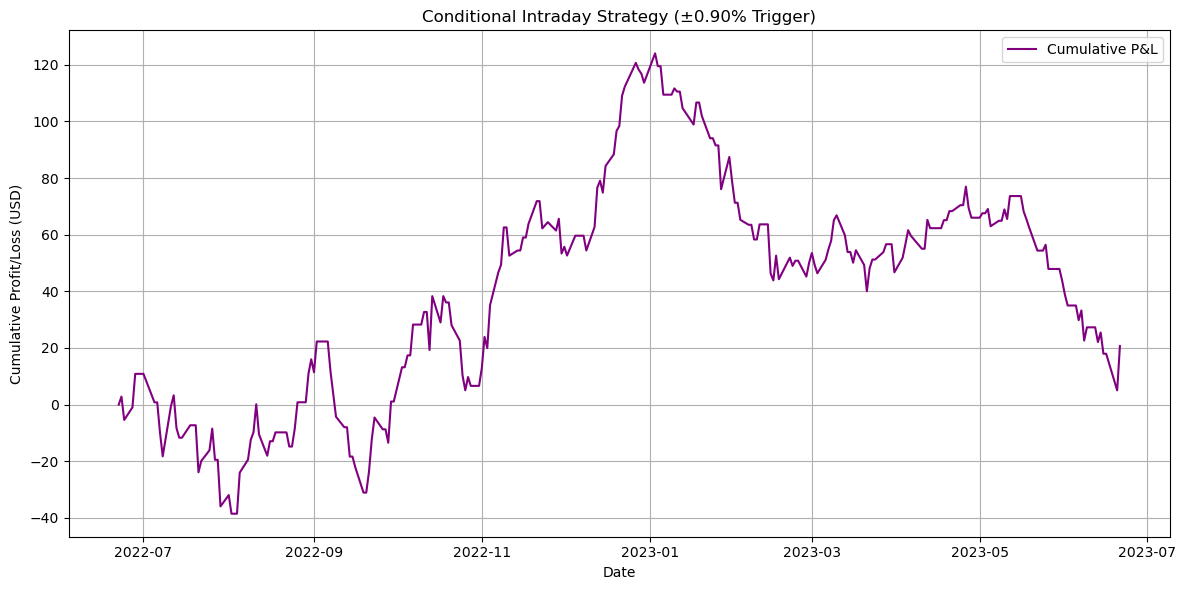

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(tesla['Date'], tesla['Cumulative_PnL'], label='Cumulative P&L', color='purple')
plt.title('Conditional Intraday Strategy (±0.90% Trigger)')
plt.xlabel('Date')
plt.ylabel('Cumulative Profit/Loss (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
print(f"Total Profit/Loss: ${tesla['PnL'].sum():.2f}")
print(f"Average Trade PnL: ${tesla.loc[tesla['Position'] != 'None', 'PnL'].mean():.2f}")
print(f"Number of Trades: {(tesla['Position'] != 'None').sum()}")
print(f"Winning Trades: {(tesla['PnL'] > 0).sum()}")
print(f"Losing Trades: {(tesla['PnL'] < 0).sum()}")

Total Profit/Loss: $20.69
Average Trade PnL: $0.11
Number of Trades: 184
Winning Trades: 95
Losing Trades: 89


### Adjusted conditional strategy with buy fix and stop loss

In [74]:
threshold = 0.5  # percent threshold to trigger trade
stop_loss_pct = 1.0  # optional stop loss (in percent)

# Clear old columns
tesla["Position"] = "None"
tesla["PnL"] = 0.0

# Intraday high/low returns from open (used for stop loss)
tesla["HighReturn"] = (tesla["High"] - tesla["Open"]) / tesla["Open"] * 100
tesla["LowReturn"] = (tesla["Low"] - tesla["Open"]) / tesla["Open"] * 100

# Loop through each row to simulate trades
for i, row in tesla.iterrows():
    ret = row["ReturnPct"]

    # ---- Long trade logic ----
    if ret >= threshold:
        tesla.at[i, "Position"] = "Long"

        # Check if stop loss is hit
        if row["LowReturn"] <= -stop_loss_pct:
            # Stop loss hit → exit at stop-loss price
            stop_price = row["Open"] * (1 - stop_loss_pct / 100)
            tesla.at[i, "PnL"] = stop_price - row["Open"]
        else:
            # Normal exit at close
            tesla.at[i, "PnL"] = row["Close"] - row["Open"]

    # ---- Short trade logic ----
    elif ret <= -threshold:
        tesla.at[i, "Position"] = "Short"

        if row["HighReturn"] >= stop_loss_pct:
            # Stop loss hit → exit at stop-loss price
            stop_price = row["Open"] * (1 + stop_loss_pct / 100)
            tesla.at[i, "PnL"] = row["Open"] - stop_price
        else:
            # Normal exit at close
            tesla.at[i, "PnL"] = row["Open"] - row["Close"]

tesla['ReturnPctTrade'] = tesla['PnL'] / tesla['Open'] * 100

# Cumulative PnL
tesla["Cumulative_PnL"] = tesla["PnL"].cumsum()


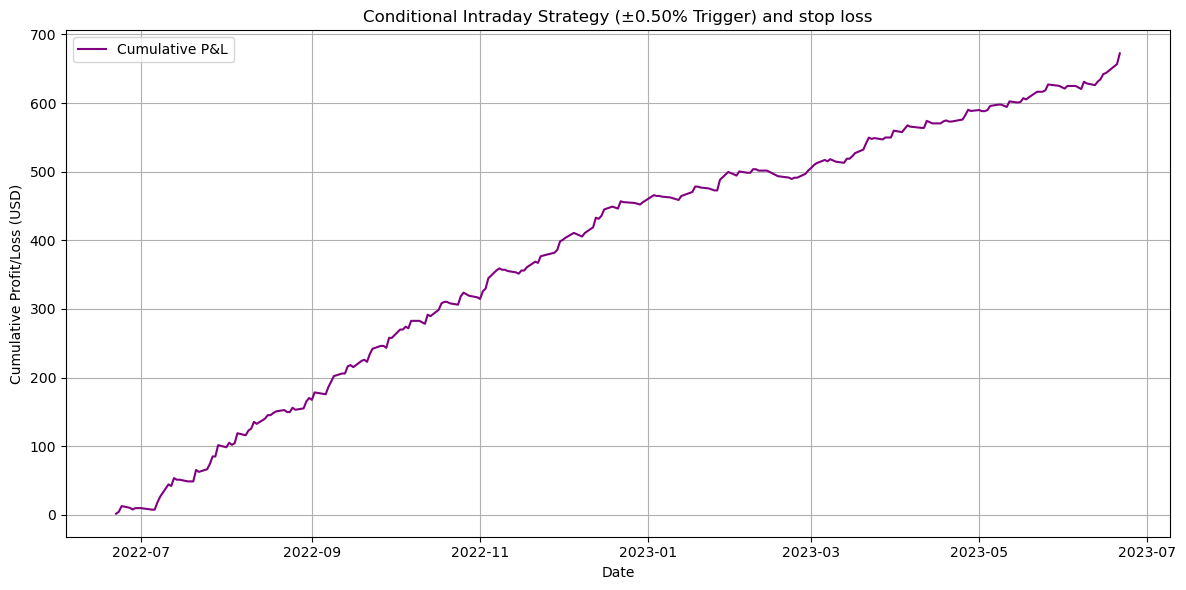

In [76]:
plt.figure(figsize=(12, 6))
plt.plot(tesla['Date'], tesla['Cumulative_PnL'], label='Cumulative P&L', color='purple')
plt.title('Conditional Intraday Strategy (±0.50% Trigger) and stop loss')
plt.xlabel('Date')
plt.ylabel('Cumulative Profit/Loss (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [78]:
trades = tesla[tesla['Position'] != 'None']

In [80]:
print(f"Total Profit/Loss: ${tesla['PnL'].sum():.2f}")
print(f"Average Trade PnL: ${tesla.loc[tesla['Position'] != 'None', 'PnL'].mean():.2f}")
print(f"Average Percent Return per Trade: {trades['ReturnPctTrade'].mean():.4f}%")
print(f"Max Return: {trades['ReturnPctTrade'].max():.2f}%")
print(f"Min Return: {trades['ReturnPctTrade'].min():.2f}%")
print(f"Number of Trades: {(tesla['Position'] != 'None').sum()}")
print(f"Winning Trades: {(tesla['PnL'] > 0).sum()}")
print(f"Losing Trades: {(tesla['PnL'] < 0).sum()}")

Total Profit/Loss: $672.35
Average Trade PnL: $3.11
Average Percent Return per Trade: 1.4468%
Max Return: 9.52%
Min Return: -1.00%
Number of Trades: 216
Winning Trades: 127
Losing Trades: 89


### Strategies performance vs buy and hold

In [83]:
total_profit = tesla['PnL'].sum()

In [85]:
total_cost = tesla.loc[tesla['Position'] != 'None', 'Open'].sum()
total_return_pct = (total_profit / total_cost) * 100

In [87]:
first_price = tesla.iloc[0]['Open']
last_price = tesla.iloc[-1]['Close']

buy_and_hold_profit = last_price - first_price
buy_and_hold_return_pct = (buy_and_hold_profit / first_price) * 100

In [89]:
# Strategy return
trades = tesla[tesla['Position'] != 'None']
total_profit = trades['PnL'].sum()
total_cost = trades['Open'].sum()
total_return_pct = (total_profit / total_cost) * 100

# Buy-and-hold return
first_price = tesla.iloc[0]['Open']
last_price = tesla.iloc[-1]['Close']
buy_and_hold_profit = last_price - first_price
buy_and_hold_return_pct = (buy_and_hold_profit / first_price) * 100

# Print summary
print(f"Total Profit from Strategy: ${total_profit:.2f}")
print(f"Total Capital Deployed: ${total_cost:.2f}")
print(f"Total Return (Strategy): {total_return_pct:.2f}%")

print(f"\nBuy and Hold Profit (1 share): ${buy_and_hold_profit:.2f}")
print(f"Buy and Hold Return: {buy_and_hold_return_pct:.2f}%")

Total Profit from Strategy: $672.35
Total Capital Deployed: $45472.95
Total Return (Strategy): 1.48%

Buy and Hold Profit (1 share): $24.96
Buy and Hold Return: 10.64%


In [91]:
# Starting capital
initial_capital = 1000

# Buy 1 share on first day, track its value over time
tesla['BuyHold_Value'] = tesla['Close'] / tesla.iloc[0]['Close'] * initial_capital

# Conditional strategy capital (starting from same base)
tesla['Strategy_Value'] = initial_capital + tesla['Cumulative_PnL']


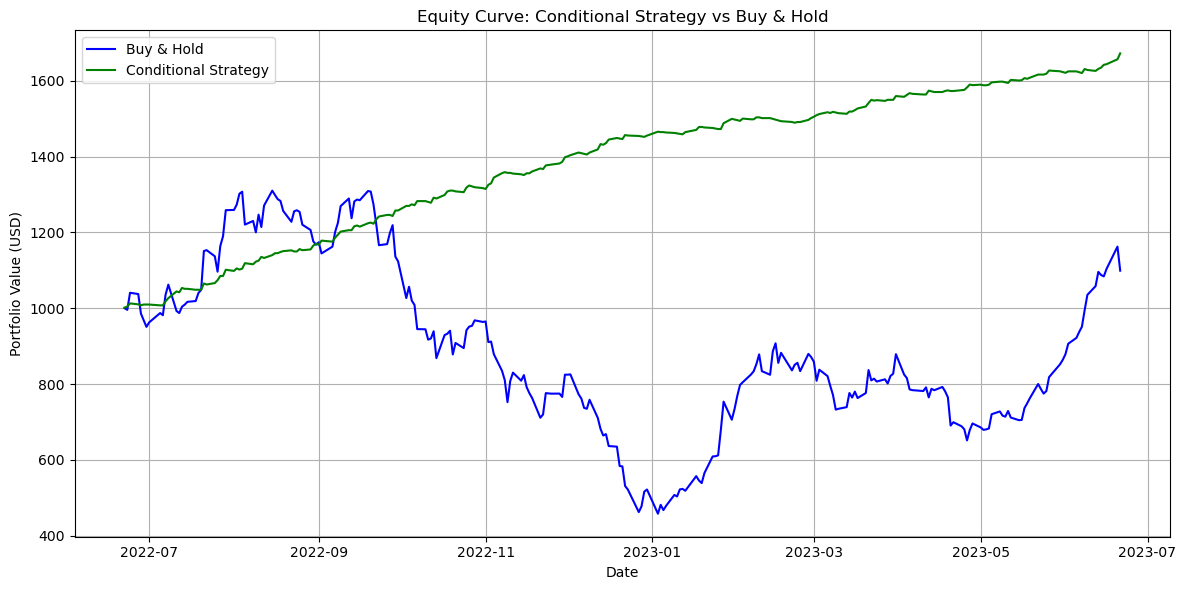

In [93]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(tesla['Date'], tesla['BuyHold_Value'], label='Buy & Hold', color='blue')
plt.plot(tesla['Date'], tesla['Strategy_Value'], label='Conditional Strategy', color='green')
plt.title('Equity Curve: Conditional Strategy vs Buy & Hold')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Adding take profit logic

In [97]:
# Parameters
threshold = 0.5  # % move from open to trigger trade
stop_loss_pct = 1.0   # % from open
take_profit_pct = 2.0 # % from open

# Clear previous results
tesla["Position"] = "None"
tesla["PnL"] = 0.0

# Calculate high/low return from open (intraday)
tesla["HighReturn"] = (tesla["High"] - tesla["Open"]) / tesla["Open"] * 100
tesla["LowReturn"] = (tesla["Low"] - tesla["Open"]) / tesla["Open"] * 100

# Main loop
for i, row in tesla.iterrows():
    ret = (row["Close"] - row["Open"]) / row["Open"] * 100  # daily move

    # Long entry condition
    if ret >= threshold:
        tesla.at[i, "Position"] = "Long"
        if row["LowReturn"] <= -stop_loss_pct:
            # Hit SL
            stop_price = row["Open"] * (1 - stop_loss_pct / 100)
            tesla.at[i, "PnL"] = stop_price - row["Open"]
        elif row["HighReturn"] >= take_profit_pct:
            # Hit TP
            tp_price = row["Open"] * (1 + take_profit_pct / 100)
            tesla.at[i, "PnL"] = tp_price - row["Open"]
        else:
            # Exit at close
            tesla.at[i, "PnL"] = row["Close"] - row["Open"]

    # Short entry condition
    elif ret <= -threshold:
        tesla.at[i, "Position"] = "Short"
        if row["HighReturn"] >= stop_loss_pct:
            stop_price = row["Open"] * (1 + stop_loss_pct / 100)
            tesla.at[i, "PnL"] = row["Open"] - stop_price
        elif row["LowReturn"] <= -take_profit_pct:
            tp_price = row["Open"] * (1 - take_profit_pct / 100)
            tesla.at[i, "PnL"] = row["Open"] - tp_price
        else:
            tesla.at[i, "PnL"] = row["Open"] - row["Close"]


In [139]:
# Parameters
threshold = 0.5  # % move from open to trigger trade
stop_loss_pct = 1.0   # % from open
take_profit_pct = 7.0 # % from open

# Clear previous results
tesla["Position"] = "None"
tesla["PnL"] = 0.0

# Calculate high/low return from open (intraday)
tesla["HighReturn"] = (tesla["High"] - tesla["Open"]) / tesla["Open"] * 100
tesla["LowReturn"] = (tesla["Low"] - tesla["Open"]) / tesla["Open"] * 100

# Main loop
for i, row in tesla.iterrows():
    ret = (row["Close"] - row["Open"]) / row["Open"] * 100  # daily move

    # Long entry condition
    if ret >= threshold:
        tesla.at[i, "Position"] = "Long"
        if row["LowReturn"] <= -stop_loss_pct:
            # Hit SL
            stop_price = row["Open"] * (1 - stop_loss_pct / 100)
            tesla.at[i, "PnL"] = stop_price - row["Open"]
        elif row["HighReturn"] >= take_profit_pct:
            # Hit TP
            tp_price = row["Open"] * (1 + take_profit_pct / 100)
            tesla.at[i, "PnL"] = tp_price - row["Open"]
        else:
            # Exit at close
            tesla.at[i, "PnL"] = row["Close"] - row["Open"]

    # Short entry condition
    elif ret <= -threshold:
        tesla.at[i, "Position"] = "Short"
        if row["HighReturn"] >= stop_loss_pct:
            stop_price = row["Open"] * (1 + stop_loss_pct / 100)
            tesla.at[i, "PnL"] = row["Open"] - stop_price
        elif row["LowReturn"] <= -take_profit_pct:
            tp_price = row["Open"] * (1 - take_profit_pct / 100)
            tesla.at[i, "PnL"] = row["Open"] - tp_price
        else:
            tesla.at[i, "PnL"] = row["Open"] - row["Close"]


In [141]:
tesla['Cumulative_PnL'] = tesla['PnL'].cumsum()
tesla['ReturnPctTrade'] = tesla['PnL'] / tesla['Open'] * 100
trades = tesla[tesla['Position'] != 'None']

# Metrics
print(f"Total Profit: ${trades['PnL'].sum():.2f}")
print(f"Average % Return per Trade: {trades['ReturnPctTrade'].mean():.2f}%")
print(f"Winning Trades: {(trades['PnL'] > 0).sum()}")
print(f"Losing Trades: {(trades['PnL'] < 0).sum()}")


Total Profit: $681.59
Average % Return per Trade: 1.46%
Winning Trades: 127
Losing Trades: 89
